Experiment 1 with IAM dataset
============================================

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import time
import os
from utils import *
from classes import *

use_gpu = torch.cuda.is_available()

print('main imports complete')

main imports complete


In [2]:
# ========================================
# Step 1. define data transform
#
# Including different forms of data augmentation
# One will include nearly all types (excluding random crops, etc. that may remove handwriting.)
# The other will include a selected set of augmentations
# Keeping 'train', 'val', and 'test' transforms just in case we want to include different functionalities
# ========================================

# Need the __name__ check to make multiprocessing work on Windows for some reason
# if __name__ == '__main__':
print("Set up data transforms.")
img_input_size = 56

selected_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        # RandomRotation does not seem to be working on Windows right now
        transforms.RandomRotation(45),

        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5),
        transforms.RandomGrayscale(p=0.1),

        transforms.Grayscale(), # not sure why the current input is not grayscale, do grayscale conversion
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    # should not do random transformation in val or test set
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
}

net1_data_transforms = {
    'train': transforms.Compose([
#         transforms.Resize(64),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Grayscale(),
        transforms.ToTensor()
        
    ]),
    'val': transforms.Compose([
#         transforms.Resize(64),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]),
    
    'test': transforms.Compose([
#         transforms.Resize(64),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]),
}

# data_transforms = selected_transforms
data_transforms = net1_data_transforms


Set up data transforms.


In [3]:
all_data_dir = '/home/rahul/data/handwriting/sampled/dim64x64-stride8x8/train_val_test-3'
set_types = ['train', 'val', 'test']

imagefolders = {t : datasets.ImageFolder(os.path.join(all_data_dir, t),
                                        transform = data_transforms[t])
               for t in set_types}
for t in set_types:
    print(str(t) + ' count:', len(imagefolders[t]))

train count: 7723
val count: 3478
test count: 2115


device_name cuda
Creating Net1.

Epoch 0/1999
----------
Phase:train
average loss: 0.2860907365833403
f1_pos: 0.8796493092454835
f1_neg: 0.8855771659509977

Phase:val
average loss: 0.5833214104621146
f1_pos: 0.6064291920069506
f1_neg: 0.8053287494628277


Epoch 1/1999
----------
Phase:train
average loss: 0.18192841163165333
f1_pos: 0.9326479504415448
f1_neg: 0.9349790049624634

Phase:val
average loss: 1.1031740029492962
f1_pos: 0.46504709965294994
f1_neg: 0.7815347236282648


Epoch 2/1999
----------
Phase:train
average loss: 0.16678624696741137
f1_pos: 0.9331041776837652
f1_neg: 0.9358030956609998

Phase:val
average loss: 0.5798524747880592
f1_pos: 0.7834008097165992
f1_neg: 0.8391783567134269


Epoch 3/1999
----------
Phase:train
average loss: 0.15980581935361524
f1_pos: 0.9364911352209581
f1_neg: 0.9391480730223124

Phase:val
average loss: 0.5108770129494177
f1_pos: 0.7657466383581034
f1_neg: 0.8397094430992735


Epoch 4/1999
----------
Phase:train
average loss: 0.16077465084833015
f

Phase:val
average loss: 2.349732910510519
f1_pos: 0.10418006430868167
f1_neg: 0.7420847991112758


Epoch 37/1999
----------
Phase:train
average loss: 0.11214386586306797
f1_pos: 0.9538054268696228
f1_neg: 0.9557723989354961

Phase:val
average loss: 1.6528772098569777
f1_pos: 0.6411378555798687
f1_neg: 0.31265716680637046


Epoch 38/1999
----------
Phase:train
average loss: 0.11453102080451227
f1_pos: 0.9493771534587861
f1_neg: 0.9516455696202532

Phase:val
average loss: 0.6985556395181367
f1_pos: 0.6827309236947792
f1_neg: 0.8231079265562025


Epoch 39/1999
----------
Phase:train
average loss: 0.10850941528960875
f1_pos: 0.9497013934970139
f1_neg: 0.9520920237643787

Phase:val
average loss: 1.793209790360866
f1_pos: 0.30231246474901297
f1_neg: 0.7613351340922246


Epoch 40/1999
----------
Phase:train
average loss: 0.10709112941944798
f1_pos: 0.9547738693467337
f1_neg: 0.95662100456621

Phase:val
average loss: 2.5861816987558095
f1_pos: 0.6233545647558386
f1_neg: 0.2101513802315227


Ep

Phase:train
average loss: 0.07808649026134325
f1_pos: 0.9628159322482467
f1_neg: 0.9643807833692484

Phase:val
average loss: 1.8210065615046909
f1_pos: 0.6479558011049724
f1_neg: 0.3447141094199918


Epoch 74/1999
----------
Phase:train
average loss: 0.09428065755153342
f1_pos: 0.9555202541699762
f1_neg: 0.9574252407501268

Phase:val
average loss: 0.5242652274741052
f1_pos: 0.8058287795992715
f1_neg: 0.8734267394918072


Epoch 75/1999
----------
Phase:train
average loss: 0.09340705648672391
f1_pos: 0.9584158415841584
f1_neg: 0.9599796722144581

Phase:val
average loss: 1.542008078667266
f1_pos: 0.653088630259624
f1_neg: 0.37700964630225076


Epoch 76/1999
----------
Phase:train
average loss: 0.09779813004652561
f1_pos: 0.9550576693623227
f1_neg: 0.9571048968746046

Phase:val
average loss: 1.4021990465802527
f1_pos: 0.8072787427626137
f1_neg: 0.7900270351456895


Epoch 77/1999
----------
Phase:train
average loss: 0.08122095438310106
f1_pos: 0.9628060886829914
f1_neg: 0.9643898111772905



Phase:train
average loss: 0.08475141965550306
f1_pos: 0.9587478445417164
f1_neg: 0.9606677627418743

Phase:val
average loss: 1.0341846038720743
f1_pos: 0.669983416252073
f1_neg: 0.4906764168190128


Epoch 111/1999
----------
Phase:train
average loss: 0.07526749990196499
f1_pos: 0.9624537281861449
f1_neg: 0.9639685359045927

Phase:val
average loss: 1.2163252321518037
f1_pos: 0.8402195897139554
f1_neg: 0.8417739628040057


Epoch 112/1999
----------
Phase:train
average loss: 0.07369650259255113
f1_pos: 0.9653445776782185
f1_neg: 0.9665266641211658

Phase:val
average loss: 0.9059099641731925
f1_pos: 0.7047244094488189
f1_neg: 0.8301630434782608


Epoch 113/1999
----------
Phase:train
average loss: 0.08135011343006394
f1_pos: 0.9656629688325409
f1_neg: 0.9669799339598679

Phase:val
average loss: 0.866683787659299
f1_pos: 0.753547423450336
f1_neg: 0.8457223001402525


Epoch 114/1999
----------
Phase:train
average loss: 0.07258210805750381
f1_pos: 0.9654535864978904
f1_neg: 0.9666751462732129

Phase:val
average loss: 0.7807904148046966
f1_pos: 0.7713437268002968
f1_neg: 0.8554669169404036


Epoch 147/1999
----------
Phase:train
average loss: 0.06656486914188893
f1_pos: 0.9677077818951826
f1_neg: 0.9690747782002535

Phase:val
average loss: 0.7614315429454976
f1_pos: 0.7917105725324903
f1_neg: 0.8556826478461913


Epoch 148/1999
----------
Phase:train
average loss: 0.0665824844754068
f1_pos: 0.9676482239535191
f1_neg: 0.9688809856471485

Phase:val
average loss: 1.0639439081583577
f1_pos: 0.679323153115972
f1_neg: 0.828590337524818


Epoch 149/1999
----------
Phase:train
average loss: 0.07436605249910826
f1_pos: 0.9637786917871832
f1_neg: 0.9654823618662283

Phase:val
average loss: 0.6463967602166587
f1_pos: 0.8103143765453903
f1_neg: 0.8698181818181818


Epoch 150/1999
----------
Phase:train
average loss: 0.07798841779237119
f1_pos: 0.9636075949367089
f1_neg: 0.9648944288984992

Phase:val
average loss: 0.7772524396087193
f1_pos: 0.8105756358768407
f1_neg: 0.857358870967742


E

Phase:train
average loss: 0.05985391352030954
f1_pos: 0.969039428420217
f1_neg: 0.9703346855983773

Phase:val
average loss: 1.100381635056617
f1_pos: 0.8526534242514081
f1_neg: 0.8612894222718392


Epoch 184/1999
----------
Phase:train
average loss: 0.0678803460841566
f1_pos: 0.9649331745401614
f1_neg: 0.9664089238179744

Phase:val
average loss: 0.8034528680681291
f1_pos: 0.8359073359073358
f1_neg: 0.8674636174636174


Epoch 185/1999
----------
Phase:train
average loss: 0.06534934366151071
f1_pos: 0.9655446594222103
f1_neg: 0.9670886075949366

Phase:val
average loss: 0.9235337972983744
f1_pos: 0.8565230864580106
f1_neg: 0.8758380262805041


Epoch 186/1999
----------
Phase:train
average loss: 0.07237877121341595
f1_pos: 0.9639352956775391
f1_neg: 0.9655870445344129

Phase:val
average loss: 0.8027639929215891
f1_pos: 0.864898210980876
f1_neg: 0.8820678513731824


Epoch 187/1999
----------
Phase:train
average loss: 0.06094834074536229
f1_pos: 0.9706153643431283
f1_neg: 0.9716176657757413


Phase:val
average loss: 0.8732048303248761
f1_pos: 0.8310322156476003
f1_neg: 0.8686765457332654


Epoch 220/1999
----------
Phase:train
average loss: 0.07277729548248589
f1_pos: 0.9654441943598568
f1_neg: 0.9669327251995439

Phase:val
average loss: 1.3138741828574059
f1_pos: 0.8353765323992994
f1_neg: 0.8402266288951842


Epoch 221/1999
----------
Phase:train
average loss: 0.062181963036749686
f1_pos: 0.9685517970401691
f1_neg: 0.9697892866209699

Phase:val
average loss: 1.4826544260690786
f1_pos: 0.6087743102668476
f1_neg: 0.8177028451001053


Epoch 222/1999
----------
Phase:train
average loss: 0.06189978933274152
f1_pos: 0.968526844750066
f1_neg: 0.9698122780314561

Phase:val
average loss: 0.8411215338781005
f1_pos: 0.7603494113178884
f1_neg: 0.8540365486930372


Epoch 223/1999
----------
Phase:train
average loss: 0.05926341713261075
f1_pos: 0.9685101878803916
f1_neg: 0.9698275862068966

Phase:val
average loss: 1.761445786159158
f1_pos: 0.6610324349017817
f1_neg: 0.4243599689681924


Phase:train
average loss: 0.06791898599362368
f1_pos: 0.9650516282764099
f1_neg: 0.9665484034465281

Phase:val
average loss: 1.1195097323667735
f1_pos: 0.8343440791573572
f1_neg: 0.8642427413026418


Epoch 257/1999
----------
Phase:train
average loss: 0.06511191728447278
f1_pos: 0.9668296550812739
f1_neg: 0.9681431653763168

Phase:val
average loss: 0.7880923361048883
f1_pos: 0.8357519788918206
f1_neg: 0.8730886850152905


Epoch 258/1999
----------
Phase:train
average loss: 0.05499798539414796
f1_pos: 0.9709225482421359
f1_neg: 0.9720812182741115

Phase:val
average loss: 0.7994296870881487
f1_pos: 0.8321701561980726
f1_neg: 0.8720547251076767


Epoch 259/1999
----------
Phase:train
average loss: 0.05888680132979265
f1_pos: 0.9700979094998677
f1_neg: 0.9713488843813388

Phase:val
average loss: 0.874590276540731
f1_pos: 0.7801047120418848
f1_neg: 0.8626809901914992


Epoch 260/1999
----------
Phase:train
average loss: 0.059084198828707024
f1_pos: 0.9715039577836412
f1_neg: 0.9725400457665

Phase:val
average loss: 0.6866971984068644
f1_pos: 0.8543111992071358
f1_neg: 0.8877576991600916


Epoch 293/1999
----------
Phase:train
average loss: 0.05142198668877981
f1_pos: 0.9700979094998677
f1_neg: 0.9713488843813388

Phase:val
average loss: 1.3118244308791946
f1_pos: 0.6778443113772455
f1_neg: 0.5163610212153902


Epoch 294/1999
----------
Phase:train
average loss: 0.05692313879653069
f1_pos: 0.9703703703703703
f1_neg: 0.9715952320568094

Phase:val
average loss: 3.9963873758475077
f1_pos: 0.25586854460093894
f1_neg: 0.7585681645087586


Epoch 295/1999
----------
Phase:train
average loss: 0.061237106706477265
f1_pos: 0.9687748081503041
f1_neg: 0.9700811359026369

Phase:val
average loss: 0.9199264010456254
f1_pos: 0.8483338523824355
f1_neg: 0.8699599465954606


Epoch 296/1999
----------
Phase:train
average loss: 0.061963275743514075
f1_pos: 0.9680738786279683
f1_neg: 0.9692346809051615

Phase:val
average loss: 3.6718349992851884
f1_pos: 0.6258271077908217
f1_neg: 0.2280933509467

Phase:train
average loss: 0.05693799839783149
f1_pos: 0.9675625579240037
f1_neg: 0.9689598378309894

Phase:val
average loss: 0.8850317620696385
f1_pos: 0.8613769682000618
f1_neg: 0.8792036588646758


Epoch 330/1999
----------
Phase:train
average loss: 0.05595384760515936
f1_pos: 0.9695525549377813
f1_neg: 0.9708565636087175

Phase:val
average loss: 0.983932770655853
f1_pos: 0.854828660436137
f1_neg: 0.8756006406833957


Epoch 331/1999
----------
Phase:train
average loss: 0.05749044818084947
f1_pos: 0.9697609930014526
f1_neg: 0.9709132478089674

Phase:val
average loss: 1.4590487885982433
f1_pos: 0.6772124839675074
f1_neg: 0.8364739008013862


Epoch 332/1999
----------
Phase:train
average loss: 0.05083151878944629
f1_pos: 0.9715570842704062
f1_neg: 0.9727399518194497

Phase:val
average loss: 1.317755130942763
f1_pos: 0.8442330558858503
f1_neg: 0.8541202672605791


Epoch 333/1999
----------
Phase:train
average loss: 0.05063205230250331
f1_pos: 0.97330866807611
f1_neg: 0.9743589743589743



Phase:val
average loss: 0.7960416119697794
f1_pos: 0.8129263913824059
f1_neg: 0.875089906497243


Epoch 366/1999
----------
Phase:train
average loss: 0.04793146887421994
f1_pos: 0.9732804232804232
f1_neg: 0.97438498605123

Phase:val
average loss: 1.2479088870597475
f1_pos: 0.7446969696969697
f1_neg: 0.8438368860055608


Epoch 367/1999
----------
Phase:train
average loss: 0.054846626345251996
f1_pos: 0.9701058201058201
f1_neg: 0.9713416180573168

Phase:val
average loss: 1.479238861727262
f1_pos: 0.6680743243243243
f1_neg: 0.8286835222319092


Epoch 368/1999
----------
Phase:train
average loss: 0.05441871685124611
f1_pos: 0.9708173775254193
f1_neg: 0.9719293788898768

Phase:val
average loss: 1.790218046233872
f1_pos: 0.6622334326989222
f1_neg: 0.4323699421965318


Epoch 369/1999
----------
Phase:train
average loss: 0.04783683596377864
f1_pos: 0.9725158562367865
f1_neg: 0.9735973597359736

Phase:val
average loss: 3.4923276440585873
f1_pos: 0.6379084967320261
f1_neg: 0.297548605240913


Ep

Phase:train
average loss: 0.04747399596069802
f1_pos: 0.9740139823242316
f1_neg: 0.9749523204068659

Phase:val
average loss: 5.6771594741825675
f1_pos: 0.16976456009913257
f1_neg: 0.7491576188693374


Epoch 403/1999
----------
Phase:train
average loss: 0.06861177420866593
f1_pos: 0.9718495132859774
f1_neg: 0.9727180010198878

Phase:val
average loss: 0.8049360622682401
f1_pos: 0.8223707351389377
f1_neg: 0.8772185752492099


Epoch 404/1999
----------
Phase:train
average loss: 0.057514158755137594
f1_pos: 0.9670067576520471
f1_neg: 0.9684770224078997

Phase:val
average loss: 4.335250704229529
f1_pos: 0.6311705108859668
f1_neg: 0.26154510142425547


Epoch 405/1999
----------
Phase:train
average loss: 0.04801708859491963
f1_pos: 0.9734793508378413
f1_neg: 0.9744502351595271

Phase:val
average loss: 1.4904669749455728
f1_pos: 0.6646706586826348
f1_neg: 0.8302295365959289


Epoch 406/1999
----------
Phase:train
average loss: 0.04732590230794655
f1_pos: 0.9755968869542277
f1_neg: 0.97647806738

Phase:val
average loss: 0.824291032748088
f1_pos: 0.8588082901554404
f1_neg: 0.8872802481902792


Epoch 439/1999
----------
Phase:train
average loss: 0.04067482220407642
f1_pos: 0.9762470308788599
f1_neg: 0.9771225216065074

Phase:val
average loss: 0.9513613112086603
f1_pos: 0.8130480533146265
f1_neg: 0.8701583434835567


Epoch 440/1999
----------
Phase:train
average loss: 0.04599825590858268
f1_pos: 0.9723215468149914
f1_neg: 0.9735275490816973

Phase:val
average loss: 1.2418811308919457
f1_pos: 0.852131841548231
f1_neg: 0.8659906823787339


Epoch 441/1999
----------
Phase:train
average loss: 0.04143402019857388
f1_pos: 0.9767626089252707
f1_neg: 0.9776422764227642

Phase:val
average loss: 2.2464367981406723
f1_pos: 0.6586418351124234
f1_neg: 0.4112808460634547


Epoch 442/1999
----------
Phase:train
average loss: 0.05168621972476754
f1_pos: 0.971451229183188
f1_neg: 0.9725888324873097

Phase:val
average loss: 0.9820547703013055
f1_pos: 0.8501431753102131
f1_neg: 0.8764752163650669




Phase:train
average loss: 0.04501728922520356
f1_pos: 0.9751152073732718
f1_neg: 0.9759266335498662

Phase:val
average loss: 1.497733888508192
f1_pos: 0.667805294619983
f1_neg: 0.8313827481577807


Epoch 476/1999
----------
Phase:train
average loss: 0.04126682872451658
f1_pos: 0.9766459955139201
f1_neg: 0.9775009533494343

Phase:val
average loss: 1.095019162900836
f1_pos: 0.8645993245317777
f1_neg: 0.8807785888077859


Epoch 477/1999
----------
Phase:train
average loss: 0.04246288001060748
f1_pos: 0.9746031746031746
f1_neg: 0.9756530560486939

Phase:val
average loss: 1.7223127013037025
f1_pos: 0.8351648351648351
f1_neg: 0.8370497427101201


Epoch 478/1999
----------
Phase:train
average loss: 0.05046545198650542
f1_pos: 0.9720418709420963
f1_neg: 0.9732877579440434

Phase:val
average loss: 4.748091424313546
f1_pos: 0.6355545908400261
f1_neg: 0.28522775649212434


Epoch 479/1999
----------
Phase:train
average loss: 0.04906114275085715
f1_pos: 0.97111817700053
f1_neg: 0.9723980754621424



Phase:val
average loss: 0.6466462085684392
f1_pos: 0.8760385510136259
f1_neg: 0.9054978464656701


Epoch 512/1999
----------
Phase:train
average loss: 0.04494719376427459
f1_pos: 0.9744877726371447
f1_neg: 0.9755107219895952

Phase:val
average loss: 1.0874909896697034
f1_pos: 0.7656432180334241
f1_neg: 0.862422997946612


Epoch 513/1999
----------
Phase:train
average loss: 0.0460979054263145
f1_pos: 0.972200158856235
f1_neg: 0.9733907754688292

Phase:val
average loss: 1.8871462997723887
f1_pos: 0.6458240285841894
f1_neg: 0.83188467246131


Epoch 514/1999
----------
Phase:train
average loss: 0.0409971666294709
f1_pos: 0.9747321074216166
f1_neg: 0.9757829339419297

Phase:val
average loss: 0.7799892251761635
f1_pos: 0.8476190476190476
f1_neg: 0.8884462151394422


Epoch 515/1999
----------
Phase:train
average loss: 0.04823261986350467
f1_pos: 0.9744063324538259
f1_neg: 0.9753368929570303

Phase:val
average loss: 1.8492295652576531
f1_pos: 0.6409335727109515
f1_neg: 0.8307952622673435


Epo

Phase:train
average loss: 0.04509973179903184
f1_pos: 0.9727441121989944
f1_neg: 0.9738843813387424

Phase:val
average loss: 1.037159113722193
f1_pos: 0.7790919496375429
f1_neg: 0.8664359861591696


Epoch 549/1999
----------
Phase:train
average loss: 0.03983816039239235
f1_pos: 0.9766089599577111
f1_neg: 0.9775352202056098

Phase:val
average loss: 0.7711155154774969
f1_pos: 0.851138353765324
f1_neg: 0.8963667398195562


Epoch 550/1999
----------
Phase:train
average loss: 0.04524252311897319
f1_pos: 0.9727657324167107
f1_neg: 0.9738645013955849

Phase:val
average loss: 5.8152380137693065
f1_pos: 0.6351968675222972
f1_neg: 0.28910555320050874


Epoch 551/1999
----------
Phase:train
average loss: 0.04368311169075634
f1_pos: 0.9774911149137818
f1_neg: 0.9782137851955662

Phase:val
average loss: 0.7839030495246572
f1_pos: 0.8455750627015406
f1_neg: 0.8965186074429772


Epoch 552/1999
----------
Phase:train
average loss: 0.04943217986265626
f1_pos: 0.9730301427815972
f1_neg: 0.97411824410048

Phase:val
average loss: 0.7098829042747008
f1_pos: 0.8765874308042981
f1_neg: 0.9024453024453025


Epoch 585/1999
----------
Phase:train
average loss: 0.037136592795037934
f1_pos: 0.9779712438992216
f1_neg: 0.9787666878575969

Phase:val
average loss: 3.5044752192812587
f1_pos: 0.5398230088495575
f1_neg: 0.809833401056481


Epoch 586/1999
----------
Phase:train
average loss: 0.04744453749519455
f1_pos: 0.9711258278145695
f1_neg: 0.9723910840932116

Phase:val
average loss: 0.906407983156372
f1_pos: 0.8141527001862198
f1_neg: 0.8831655350035121


Epoch 587/1999
----------
Phase:train
average loss: 0.04216731790943759
f1_pos: 0.9782465392221491
f1_neg: 0.9790103040325657

Phase:val
average loss: 1.9644393288177482
f1_pos: 0.6890536415176625
f1_neg: 0.8470941453999572


Epoch 588/1999
----------
Phase:train
average loss: 0.045154983271962504
f1_pos: 0.9752481800132363
f1_neg: 0.9763021163350653

Phase:val
average loss: 4.394085054907599
f1_pos: 0.4143468950749465
f1_neg: 0.7849842767295597


Phase:train
average loss: 0.039859866490678034
f1_pos: 0.9753903148981212
f1_neg: 0.9764198782961461

Phase:val
average loss: 4.374268852478475
f1_pos: 0.6373721992603872
f1_neg: 0.29334463755828744


Epoch 622/1999
----------
Phase:train
average loss: 0.047059181158262166
f1_pos: 0.9754423026142064
f1_neg: 0.9763719512195123

Phase:val
average loss: 0.6399830847447325
f1_pos: 0.8764119601328904
f1_neg: 0.9057273188038519


Epoch 623/1999
----------
Phase:train
average loss: 0.039602590944421666
f1_pos: 0.9806553493880774
f1_neg: 0.9812667261373774

Phase:val
average loss: 1.984143548754867
f1_pos: 0.6169522927281149
f1_neg: 0.8276005836981447


Epoch 624/1999
----------
Phase:train
average loss: 0.03724035131090835
f1_pos: 0.9787458745874588
f1_neg: 0.9795451657985009

Phase:val
average loss: 1.174669185063152
f1_pos: 0.8501951365956169
f1_neg: 0.8623448275862069


Epoch 625/1999
----------
Phase:train
average loss: 0.035536815809598714
f1_pos: 0.9776661821065151
f1_neg: 0.97855057748

Phase:val
average loss: 2.0559251968582313
f1_pos: 0.6720629047178537
f1_neg: 0.4612462006079027


Epoch 658/1999
----------
Phase:train
average loss: 0.06052851022509843
f1_pos: 0.9686466463817966
f1_neg: 0.9699505515405098

Phase:val
average loss: 0.5871678860863438
f1_pos: 0.8802171700033933
f1_neg: 0.911948116737341


Epoch 659/1999
----------
Phase:train
average loss: 0.04378297765839714
f1_pos: 0.9735309687665431
f1_neg: 0.9746514575411914

Phase:val
average loss: 0.6319706561820407
f1_pos: 0.8732876712328768
f1_neg: 0.9083250743310207


Epoch 660/1999
----------
Phase:train
average loss: 0.04655401098657562
f1_pos: 0.975287432271706
f1_neg: 0.9762660236070567

Phase:val
average loss: 4.2873999816100445
f1_pos: 0.3198634035287422
f1_neg: 0.7701481054048855


Epoch 661/1999
----------
Phase:train
average loss: 0.04060049464912376
f1_pos: 0.9774436090225564
f1_neg: 0.9782581055308328

Phase:val
average loss: 4.076381020740643
f1_pos: 0.45430809399477806
f1_neg: 0.792699861138663




Phase:train
average loss: 0.043903421355906073
f1_pos: 0.9760929863954563
f1_neg: 0.977015873015873

Phase:val
average loss: 0.7203883919104411
f1_pos: 0.8612926652142339
f1_neg: 0.9090909090909091


Epoch 695/1999
----------
Phase:train
average loss: 0.03844516071807253
f1_pos: 0.977536997885835
f1_neg: 0.9784209190149784

Phase:val
average loss: 1.776345943979589
f1_pos: 0.8424101969872537
f1_neg: 0.8447488584474886


Epoch 696/1999
----------
Phase:train
average loss: 0.04456912792365186
f1_pos: 0.9727513227513227
f1_neg: 0.9738777580522444

Phase:val
average loss: 3.9630838948601346
f1_pos: 0.4997455470737914
f1_neg: 0.8030454818673611


Epoch 697/1999
----------
Phase:train
average loss: 0.036623109784835725
f1_pos: 0.9778247096092925
f1_neg: 0.9786531130876746

Phase:val
average loss: 0.7201496167660034
f1_pos: 0.8648451730418943
f1_neg: 0.9118974115412016


Epoch 698/1999
----------
Phase:train
average loss: 0.03631006121975744
f1_pos: 0.9780771262546223
f1_neg: 0.97891795783591

Phase:val
average loss: 1.022182879604232
f1_pos: 0.6958490566037736
f1_neg: 0.5944313988594432


Epoch 731/1999
----------
Phase:train
average loss: 0.038803092346210856
f1_pos: 0.974847762774689
f1_neg: 0.9759249873289407

Phase:val
average loss: 2.3585665819629846
f1_pos: 0.6522131887985547
f1_neg: 0.8376212568536482


Epoch 732/1999
----------
Phase:train
average loss: 0.04021209272300716
f1_pos: 0.9748344370860927
f1_neg: 0.9759371833839918

Phase:val
average loss: 1.7448386195886403
f1_pos: 0.8349570200573065
f1_neg: 0.8338141950375072


Epoch 733/1999
----------
Phase:train
average loss: 0.04308577941854345
f1_pos: 0.9740121983558738
f1_neg: 0.9752024291497975

Phase:val
average loss: 6.948138369164843
f1_pos: 0.6333765672287074
f1_neg: 0.27210300429184553


Epoch 734/1999
----------
Phase:train
average loss: 0.05138707143246981
f1_pos: 0.9714210108494311
f1_neg: 0.9726166328600405

Phase:val
average loss: 4.9403100578588885
f1_pos: 0.6467727674624226
f1_neg: 0.3429276315789474


Phase:train
average loss: 0.03452606472977533
f1_pos: 0.9790043575861613
f1_neg: 0.9798043947669248

Phase:val
average loss: 1.0959824633502357
f1_pos: 0.6895859473023839
f1_neg: 0.583641871423763


Epoch 768/1999
----------
Phase:train
average loss: 0.034636653439808915
f1_pos: 0.9771496499801877
f1_neg: 0.9780317460317459

Phase:val
average loss: 4.594464855676687
f1_pos: 0.6402625820568928
f1_neg: 0.3109807208717519


Epoch 769/1999
----------
Phase:train
average loss: 0.03850341413788006
f1_pos: 0.9782178217821781
f1_neg: 0.9790369711599543

Phase:val
average loss: 4.431714132093986
f1_pos: 0.40648648648648655
f1_neg: 0.7849588719153936


Epoch 770/1999
----------
Phase:train
average loss: 0.039577052300138936
f1_pos: 0.9729514717581543
f1_neg: 0.9741902834008098

Phase:val
average loss: 2.272672741354163
f1_pos: 0.683076923076923
f1_neg: 0.8459730826746422


Epoch 771/1999
----------
Phase:train
average loss: 0.04228497162993328
f1_pos: 0.9766459955139201
f1_neg: 0.977500953349434

Phase:val
average loss: 0.7326372373439993
f1_pos: 0.8494152046783625
f1_neg: 0.9023696682464456


Epoch 804/1999
----------
Phase:train
average loss: 0.03414575725483513
f1_pos: 0.9791446673706442
f1_neg: 0.9799237611181703

Phase:val
average loss: 0.6318120027219104
f1_pos: 0.8856951871657753
f1_neg: 0.9137235116044399


Epoch 805/1999
----------
Phase:train
average loss: 0.03696901984037678
f1_pos: 0.9750927397986222
f1_neg: 0.9761965054444163

Phase:val
average loss: 0.6587162299907502
f1_pos: 0.8813328799727984
f1_neg: 0.9130759651307595


Epoch 806/1999
----------
Phase:train
average loss: 0.033210298815597665
f1_pos: 0.9788695192815636
f1_neg: 0.9796799593599187

Phase:val
average loss: 0.7582160524933965
f1_pos: 0.8689895470383275
f1_neg: 0.9079784630445424


Epoch 807/1999
----------
Phase:train
average loss: 0.03583514561807195
f1_pos: 0.9774138158763703
f1_neg: 0.9782857142857142

Phase:val
average loss: 0.857889437243608
f1_pos: 0.8771586836102965
f1_neg: 0.903010033444816


Phase:train
average loss: 0.03842856524982235
f1_pos: 0.9790043575861613
f1_neg: 0.9798043947669248

Phase:val
average loss: 2.264598761570049
f1_pos: 0.6412844036697247
f1_neg: 0.8362646566164154


Epoch 841/1999
----------
Phase:train
average loss: 0.052148949142948715
f1_pos: 0.9738441215323647
f1_neg: 0.9748603351955307

Phase:val
average loss: 0.67940758668259
f1_pos: 0.8605633802816901
f1_neg: 0.9037900874635569


Epoch 842/1999
----------
Phase:train
average loss: 0.03476662893271768
f1_pos: 0.9773959021810972
f1_neg: 0.9783022459078797

Phase:val
average loss: 0.5951396844865536
f1_pos: 0.8784853700516351
f1_neg: 0.912861021969884


Epoch 843/1999
----------
Phase:train
average loss: 0.033776676152440524
f1_pos: 0.9803559657218194
f1_neg: 0.981045668490014

Phase:val
average loss: 0.5810057492075191
f1_pos: 0.8786044855820577
f1_neg: 0.9177718832891246


Epoch 844/1999
----------
Phase:train
average loss: 0.03555902404260606
f1_pos: 0.9804800844104458
f1_neg: 0.9811800610376399

Phase:val
average loss: 1.1717980338829286
f1_pos: 0.8724628900333231
f1_neg: 0.8848153214774283


Epoch 877/1999
----------
Phase:train
average loss: 0.03718693362937913
f1_pos: 0.9750927397986222
f1_neg: 0.9761965054444163

Phase:val
average loss: 0.8462913764352563
f1_pos: 0.8860598345003182
f1_neg: 0.9061352910330361


Epoch 878/1999
----------
Phase:train
average loss: 0.03501057473475469
f1_pos: 0.976158940397351
f1_neg: 0.9772036474164133

Phase:val
average loss: 0.6425969512761496
f1_pos: 0.889416553595658
f1_neg: 0.9186626746506986


Epoch 879/1999
----------
Phase:train
average loss: 0.03385490266199278
f1_pos: 0.9795271430458328
f1_neg: 0.9803174603174604

Phase:val
average loss: 0.8736201594655989
f1_pos: 0.8393939393939395
f1_neg: 0.901760889712697


Epoch 880/1999
----------
Phase:train
average loss: 0.036150776953526274
f1_pos: 0.9782005548949664
f1_neg: 0.9790529389361433

Phase:val
average loss: 0.6688831981877749
f1_pos: 0.8873517786561264
f1_neg: 0.9127551020408163



Phase:train
average loss: 0.03846258673130517
f1_pos: 0.9753838009528852
f1_neg: 0.9764258555133078

Phase:val
average loss: 0.6118655379233928
f1_pos: 0.8943965517241379
f1_neg: 0.9295302013422819


Epoch 914/1999
----------
Phase:train
average loss: 0.03125595491393277
f1_pos: 0.9784590987181181
f1_neg: 0.9793120954435842

Phase:val
average loss: 1.2023822539424402
f1_pos: 0.8025579536370903
f1_neg: 0.8890884598114055


Epoch 915/1999
----------
Phase:train
average loss: 0.03979770598901024
f1_pos: 0.9751388521555144
f1_neg: 0.9761542364282091

Phase:val
average loss: 5.046516952876595
f1_pos: 0.6500784577449003
f1_neg: 0.3743486973947896


Epoch 916/1999
----------
Phase:train
average loss: 0.03227375297775864
f1_pos: 0.9775251189846642
f1_neg: 0.9784318700837351

Phase:val
average loss: 0.7611685818197262
f1_pos: 0.8643178410794603
f1_neg: 0.9155783582089552


Epoch 917/1999
----------
Phase:train
average loss: 0.03395595286792417
f1_pos: 0.9772486772486773
f1_neg: 0.97818919604362

Phase:val
average loss: 0.9241784731501338
f1_pos: 0.8674941294867494
f1_neg: 0.9006289308176101


Epoch 950/1999
----------
Phase:train
average loss: 0.03694134719730597
f1_pos: 0.9788806758183738
f1_neg: 0.9796696315120712

Phase:val
average loss: 0.6525399151926002
f1_pos: 0.8818505338078291
f1_neg: 0.9199228171731789


Epoch 951/1999
----------
Phase:train
average loss: 0.03386041084498603
f1_pos: 0.9783469764985476
f1_neg: 0.9791666666666665

Phase:val
average loss: 1.806142307068165
f1_pos: 0.7203791469194312
f1_neg: 0.8599784250269686


Epoch 952/1999
----------
Phase:train
average loss: 0.03614588033087879
f1_pos: 0.9740053050397878
f1_neg: 0.9752087022514545

Phase:val
average loss: 1.0978327023530567
f1_pos: 0.8233450842146495
f1_neg: 0.8975698387463094


Epoch 953/1999
----------
Phase:train
average loss: 0.039314765109309535
f1_pos: 0.9746852220013253
f1_neg: 0.9758258448297683

Phase:val
average loss: 0.6072558323633678
f1_pos: 0.8982698961937716
f1_neg: 0.9276930644367928

Phase:train
average loss: 0.039132985491780715
f1_pos: 0.9745493107104984
f1_neg: 0.9757023538344723

Phase:val
average loss: 1.6338399131110237
f1_pos: 0.7916006339144216
f1_neg: 0.8813176895306859


Epoch 987/1999
----------
Phase:train
average loss: 0.045321056616612815
f1_pos: 0.9781175850250462
f1_neg: 0.9788804071246819

Phase:val
average loss: 27.39218162462038
f1_pos: 0.5971544715447155
f1_neg: 0.026522593320235755


Epoch 988/1999
----------
Phase:train
average loss: 0.03445992124915936
f1_pos: 0.979155672823219
f1_neg: 0.9799135519959318

Phase:val
average loss: 0.9587376429268243
f1_pos: 0.8462998102466793
f1_neg: 0.9062716963665819


Epoch 989/1999
----------
Phase:train
average loss: 0.03555495411263849
f1_pos: 0.9775191748214758
f1_neg: 0.9784373414510401

Phase:val
average loss: 3.631666628501414
f1_pos: 0.6489597166888004
f1_neg: 0.3494667760459393


Epoch 990/1999
----------
Phase:train
average loss: 0.03482379522316894
f1_pos: 0.9784534038334436
f1_neg: 0.979317345514

Phase:val
average loss: 0.63492576756513
f1_pos: 0.8903313973351554
f1_neg: 0.9203276247207745


Epoch 1023/1999
----------
Phase:train
average loss: 0.04063059793348736
f1_pos: 0.9759767687434002
f1_neg: 0.976874205844981

Phase:val
average loss: 1.621803526737143
f1_pos: 0.8096313017306246
f1_neg: 0.8822708236389017


Epoch 1024/1999
----------
Phase:train
average loss: 0.09970098683953277
f1_pos: 0.966009787065203
f1_neg: 0.9674064679771718

Phase:val
average loss: 0.470985090873103
f1_pos: 0.8980418636056718
f1_neg: 0.9243865798698049


Epoch 1025/1999
----------
Phase:train
average loss: 0.03804241527616206
f1_pos: 0.977143612101995
f1_neg: 0.9780373238542592

Phase:val
average loss: 0.48469851605161435
f1_pos: 0.8973924822214697
f1_neg: 0.9243067699225581


Epoch 1026/1999
----------
Phase:train
average loss: 0.03778993293631421
f1_pos: 0.9765842042598227
f1_neg: 0.9775580068467098

Phase:val
average loss: 0.4875389555701584
f1_pos: 0.8972820331803741
f1_neg: 0.9294203250060635



Phase:train
average loss: 0.03227289937401632
f1_pos: 0.9761652542372882
f1_neg: 0.9771978718013682

Phase:val
average loss: 0.622042892478265
f1_pos: 0.8851851851851852
f1_neg: 0.9271616541353385


Epoch 1060/1999
----------
Phase:train
average loss: 0.037728271567471695
f1_pos: 0.9760360121805906
f1_neg: 0.9770682883567718

Phase:val
average loss: 0.9548396500724016
f1_pos: 0.8782904924125116
f1_neg: 0.8945532599946336


Epoch 1061/1999
----------
Phase:train
average loss: 0.03212924751920813
f1_pos: 0.9804903770102821
f1_neg: 0.9811704834605599

Phase:val
average loss: 0.49670710887217945
f1_pos: 0.906832298136646
f1_neg: 0.9268668206312548


Epoch 1062/1999
----------
Phase:train
average loss: 0.03003996772082006
f1_pos: 0.9811519704758138
f1_neg: 0.9818043008016287

Phase:val
average loss: 0.45255928885463736
f1_pos: 0.9120916133378241
f1_neg: 0.9345372460496614


Epoch 1063/1999
----------
Phase:train
average loss: 0.03662174572313411
f1_pos: 0.9776720834984807
f1_neg: 0.97854513

Phase:val
average loss: 1.3911815592446088
f1_pos: 0.8660848630755342
f1_neg: 0.8775116983209468


Epoch 1096/1999
----------
Phase:train
average loss: 0.035732582905434074
f1_pos: 0.9801289643374129
f1_neg: 0.9807569771887346

Phase:val
average loss: 5.02739722705422
f1_pos: 0.6452612931798052
f1_neg: 0.3434426229508197


Epoch 1097/1999
----------
Phase:train
average loss: 0.043090950782300096
f1_pos: 0.9737887212073075
f1_neg: 0.9749113025848961

Phase:val
average loss: 1.5070375111543153
f1_pos: 0.8066958947787963
f1_neg: 0.8909377108162806


Epoch 1098/1999
----------
Phase:train
average loss: 0.03603992535563449
f1_pos: 0.9776602775941838
f1_neg: 0.978556020809542

Phase:val
average loss: 0.5100626769663618
f1_pos: 0.9060585432266848
f1_neg: 0.9313091090094574


Epoch 1099/1999
----------
Phase:train
average loss: 0.0337567437203701
f1_pos: 0.9773899246330822
f1_neg: 0.978307750856273

Phase:val
average loss: 7.350857567416997
f1_pos: 0.6262798634812287
f1_neg: 0.2275132275132275

Phase:train
average loss: 0.037399568513623534
f1_pos: 0.9774078478002379
f1_neg: 0.9782912276247303

Phase:val
average loss: 1.0125337664322855
f1_pos: 0.8860681114551083
f1_neg: 0.9012345679012346


Epoch 1133/1999
----------
Phase:train
average loss: 0.03233761439505334
f1_pos: 0.9788639365918098
f1_neg: 0.9796851193499237

Phase:val
average loss: 0.5696512988204583
f1_pos: 0.899194847020934
f1_neg: 0.9187224097636978


Epoch 1134/1999
----------
Phase:train
average loss: 0.035318038418018866
f1_pos: 0.977654369959011
f1_neg: 0.9785614613725738

Phase:val
average loss: 1.1401308600144389
f1_pos: 0.8304498269896193
f1_neg: 0.8987370838117107


Epoch 1135/1999
----------
Phase:train
average loss: 0.03814209505201925
f1_pos: 0.9769098825702599
f1_neg: 0.97775517986526

Phase:val
average loss: 0.9892907857620695
f1_pos: 0.8314087759815243
f1_neg: 0.8994951812758146


Epoch 1136/1999
----------
Phase:train
average loss: 0.03381424817158137
f1_pos: 0.9776602775941838
f1_neg: 0.97855602080

Phase:val
average loss: 0.8977729392726919
f1_pos: 0.8498475609756097
f1_neg: 0.9090489381348108


Epoch 1169/1999
----------
Phase:train
average loss: 0.03700239297163422
f1_pos: 0.9781002638522427
f1_neg: 0.9788965166539538

Phase:val
average loss: 0.5952803373439618
f1_pos: 0.9012261580381471
f1_neg: 0.927860696517413


Epoch 1170/1999
----------
Phase:train
average loss: 0.04816498627053376
f1_pos: 0.9729514717581543
f1_neg: 0.9741902834008098

Phase:val
average loss: 1.303126900000021
f1_pos: 0.7913079130791307
f1_neg: 0.8873145893292007


Epoch 1171/1999
----------
Phase:train
average loss: 0.04011765593706512
f1_pos: 0.9753772835583796
f1_neg: 0.976431829700963

Phase:val
average loss: 0.6302408719282167
f1_pos: 0.8911880128433822
f1_neg: 0.9265591138935709


Epoch 1172/1999
----------
Phase:train
average loss: 0.03468296302946278
f1_pos: 0.9802267334563671
f1_neg: 0.9809160305343512

Phase:val
average loss: 0.47781919748396484
f1_pos: 0.908336215842269
f1_neg: 0.934809348093481

Phase:train
average loss: 0.03415370853546639
f1_pos: 0.9773839439227616
f1_neg: 0.9783132530120482

Phase:val
average loss: 1.8079355118122507
f1_pos: 0.7648278722521775
f1_neg: 0.8752475247524752


Epoch 1206/1999
----------
Phase:train
average loss: 0.032552708051750846
f1_pos: 0.9810376613115617
f1_neg: 0.9816607233825778

Phase:val
average loss: 0.5446139182799022
f1_pos: 0.9037380086007277
f1_neg: 0.9260106788710908


Epoch 1207/1999
----------
Phase:train
average loss: 0.033381993480429015
f1_pos: 0.9784704794611015
f1_neg: 0.9793015873015873

Phase:val
average loss: 1.6064707415757884
f1_pos: 0.8213017751479289
f1_neg: 0.8975344944582674


Epoch 1208/1999
----------
Phase:train
average loss: 0.03672758694770483
f1_pos: 0.977654369959011
f1_neg: 0.9785614613725738

Phase:val
average loss: 5.213681763105519
f1_pos: 0.6463658590797955
f1_neg: 0.35246235246235247


Epoch 1209/1999
----------
Phase:train
average loss: 0.03611354363373777
f1_pos: 0.9771254793071532
f1_neg: 0.97805404

Phase:val
average loss: 0.758465289983892
f1_pos: 0.8826131337189521
f1_neg: 0.9141150112023898


Epoch 1242/1999
----------
Phase:train
average loss: 0.034633371602031414
f1_pos: 0.9750993377483443
f1_neg: 0.9761904761904763

Phase:val
average loss: 0.5437042301005506
f1_pos: 0.905186653452263
f1_neg: 0.9269534232629169


Epoch 1243/1999
----------
Phase:train
average loss: 0.030401149578672126
f1_pos: 0.979268453717153
f1_neg: 0.9800584275371522

Phase:val
average loss: 1.6306443861533062
f1_pos: 0.8363009764503159
f1_neg: 0.8359240069084629


Epoch 1244/1999
----------
Phase:train
average loss: 0.033467261044162144
f1_pos: 0.9780829152363348
f1_neg: 0.9789126016260162

Phase:val
average loss: 3.58398167575619
f1_pos: 0.5707340787554691
f1_neg: 0.8197591345172485


Epoch 1245/1999
----------
Phase:train
average loss: 0.04731745012893175
f1_pos: 0.9744742758894326
f1_neg: 0.9755231452124287

Phase:val
average loss: 0.9192471735912058
f1_pos: 0.8533535430087156
f1_neg: 0.91035441278665

Phase:train
average loss: 0.038270807554784965
f1_pos: 0.9755323369924613
f1_neg: 0.9765377298668357

Phase:val
average loss: 0.8796682844153761
f1_pos: 0.8652908067542214
f1_neg: 0.9163365182941039


Epoch 1279/1999
----------
Phase:train
average loss: 0.03762267130808974
f1_pos: 0.9802267334563671
f1_neg: 0.9809160305343512

Phase:val
average loss: 1.1045955600170927
f1_pos: 0.8752271350696548
f1_neg: 0.8872468527640943


Epoch 1280/1999
----------
Phase:train
average loss: 0.03609897084481108
f1_pos: 0.9756291390728477
f1_neg: 0.9766970618034447

Phase:val
average loss: 0.621981920259927
f1_pos: 0.9001996007984032
f1_neg: 0.9240506329113924


Epoch 1281/1999
----------
Phase:train
average loss: 0.03590236932920056
f1_pos: 0.97791881528494
f1_neg: 0.9788151718888749

Phase:val
average loss: 0.8660917174480234
f1_pos: 0.870321361058601
f1_neg: 0.9204360937137556


Epoch 1282/1999
----------
Phase:train
average loss: 0.03426447946027888
f1_pos: 0.9777836551176938
f1_neg: 0.978691019786

Phase:val
average loss: 0.9581840078230217
f1_pos: 0.701086956521739
f1_neg: 0.5839064649243466


Epoch 1315/1999
----------
Phase:train
average loss: 0.035234842027841294
f1_pos: 0.9775191748214758
f1_neg: 0.9784373414510401

Phase:val
average loss: 0.4543371042552661
f1_pos: 0.9094005449591281
f1_neg: 0.9338308457711444


Epoch 1316/1999
----------
Phase:train
average loss: 0.0350111617634241
f1_pos: 0.9781947931809172
f1_neg: 0.9790582561238735

Phase:val
average loss: 0.4830257155005448
f1_pos: 0.9085386432669592
f1_neg: 0.9321312296518909


Epoch 1317/1999
----------
Phase:train
average loss: 0.032188948498815484
f1_pos: 0.9756032882524529
f1_neg: 0.9767206477732794

Phase:val
average loss: 0.6930042181534627
f1_pos: 0.8829160530191458
f1_neg: 0.925


Epoch 1318/1999
----------
Phase:train
average loss: 0.03278799228120326
f1_pos: 0.9788639365918098
f1_neg: 0.9796851193499237

Phase:val
average loss: 3.840570849341315
f1_pos: 0.6364425162689804
f1_neg: 0.28559249786871277


Epoch 

Phase:train
average loss: 0.03658071941773346
f1_pos: 0.9748077433041632
f1_neg: 0.9759615384615384

Phase:val
average loss: 0.5523350987628385
f1_pos: 0.9047127622979015
f1_neg: 0.9315880464312176


Epoch 1352/1999
----------
Phase:train
average loss: 0.03673212654902136
f1_pos: 0.9760296649450405
f1_neg: 0.9770740975300823

Phase:val
average loss: 1.92365527557463
f1_pos: 0.7407407407407407
f1_neg: 0.867809854569134


Epoch 1353/1999
----------
Phase:train
average loss: 0.03568988136930755
f1_pos: 0.9768303985171455
f1_neg: 0.9778284555935639

Phase:val
average loss: 0.47427886361154487
f1_pos: 0.9115832762165869
f1_neg: 0.9361069836552749


Epoch 1354/1999
----------
Phase:train
average loss: 0.030411267378643032
f1_pos: 0.9777777777777777
f1_neg: 0.9786964240426071

Phase:val
average loss: 0.8059135732327198
f1_pos: 0.8814055636896047
f1_neg: 0.9232954545454546


Epoch 1355/1999
----------
Phase:train
average loss: 0.03351055907593707
f1_pos: 0.9757455268389662
f1_neg: 0.9768383748

Phase:val
average loss: 0.7203228795079406
f1_pos: 0.8960805465659833
f1_neg: 0.9307784431137724


Epoch 1388/1999
----------
Phase:train
average loss: 0.033050935849292695
f1_pos: 0.9764363251257613
f1_neg: 0.9774455144450076

Phase:val
average loss: 0.6769466701939985
f1_pos: 0.8948332722609015
f1_neg: 0.9321031464395553


Epoch 1389/1999
----------
Phase:train
average loss: 0.030708165418452647
f1_pos: 0.979009900990099
f1_neg: 0.9797992631177742

Phase:val
average loss: 0.580753447801783
f1_pos: 0.9074507183427999
f1_neg: 0.9301034569770376


Epoch 1390/1999
----------
Phase:train
average loss: 0.03338005443137498
f1_pos: 0.979155672823219
f1_neg: 0.9799135519959318

Phase:val
average loss: 0.4773371686720862
f1_pos: 0.9190116678105696
f1_neg: 0.9416130628401782


Epoch 1391/1999
----------
Phase:train
average loss: 0.030348698630283593
f1_pos: 0.9788639365918098
f1_neg: 0.9796851193499237

Phase:val
average loss: 0.6974980240583831
f1_pos: 0.8965014577259475
f1_neg: 0.932573599240

Phase:train
average loss: 0.03359397473885777
f1_pos: 0.9785940803382663
f1_neg: 0.9794364051789793

Phase:val
average loss: 1.93855189978905
f1_pos: 0.7606338615512929
f1_neg: 0.8740675734971478


Epoch 1425/1999
----------
Phase:train
average loss: 0.031078251924307392
f1_pos: 0.9770951939626639
f1_neg: 0.9780818446724946

Phase:val
average loss: 0.5492139748881918
f1_pos: 0.9101836393989984
f1_neg: 0.9320878566018682


Epoch 1426/1999
----------
Phase:train
average loss: 0.03264709688755888
f1_pos: 0.979403221547399
f1_neg: 0.9801829268292683

Phase:val
average loss: 0.5735743432088856
f1_pos: 0.9063224097980801
f1_neg: 0.9280813214739518


Epoch 1427/1999
----------
Phase:train
average loss: 0.04490959493627392
f1_pos: 0.9745079910183595
f1_neg: 0.9754920634920634

Phase:val
average loss: 1.3120795470191666
f1_pos: 0.8375089477451682
f1_neg: 0.8909178279673233


Epoch 1428/1999
----------
Phase:train
average loss: 0.04312355698848152
f1_pos: 0.9771797915842236
f1_neg: 0.97800381436

Phase:val
average loss: 2.040590557783345
f1_pos: 0.7558724832214765
f1_neg: 0.8727034120734908


Epoch 1461/1999
----------
Phase:train
average loss: 0.031324934481507354
f1_pos: 0.9785997357992074
f1_neg: 0.9794311833417979

Phase:val
average loss: 0.583492155182012
f1_pos: 0.9062715368711234
f1_neg: 0.932905772076961


Epoch 1462/1999
----------
Phase:train
average loss: 0.030863585557379083
f1_pos: 0.979268453717153
f1_neg: 0.9800584275371522

Phase:val
average loss: 1.7140560719115492
f1_pos: 0.8532863849765259
f1_neg: 0.859075535512965


Epoch 1463/1999
----------
Phase:train
average loss: 0.03314020233012945
f1_pos: 0.9764300847457626
f1_neg: 0.9774512287813529

Phase:val
average loss: 0.8810435300451918
f1_pos: 0.8770550393137955
f1_neg: 0.9172679172679172


Epoch 1464/1999
----------
Phase:train
average loss: 0.033464509103325844
f1_pos: 0.9785884218873909
f1_neg: 0.9794416243654822

Phase:val
average loss: 0.6675330984517032
f1_pos: 0.900355871886121
f1_neg: 0.932465026531596

Phase:train
average loss: 0.0475612255969779
f1_pos: 0.9744877726371447
f1_neg: 0.9755107219895952

Phase:val
average loss: 0.8317209913718282
f1_pos: 0.8674388674388674
f1_neg: 0.8929313929313929


Epoch 1498/1999
----------
Phase:train
average loss: 0.03104771341355287
f1_pos: 0.9785940803382663
f1_neg: 0.9794364051789793

Phase:val
average loss: 0.6944233371033759
f1_pos: 0.8827433628318585
f1_neg: 0.9250706880301602


Epoch 1499/1999
----------
Phase:train
average loss: 0.03818348301525146
f1_pos: 0.9769962982548916
f1_neg: 0.9779243846739406

Phase:val
average loss: 4.909341727405392
f1_pos: 0.6292327475353622
f1_neg: 0.24454148471615716


Epoch 1500/1999
----------
Phase:train
average loss: 0.03568893089426447
f1_pos: 0.9757647993643227
f1_neg: 0.9768207726409119

Phase:val
average loss: 0.6609269626837068
f1_pos: 0.891891891891892
f1_neg: 0.9266409266409267


Epoch 1501/1999
----------
Phase:train
average loss: 0.03482191619395372
f1_pos: 0.9776484591985187
f1_neg: 0.97856689917

Phase:val
average loss: 4.374761541798719
f1_pos: 0.6578164339665827
f1_neg: 0.42211055276381904


Epoch 1534/1999
----------
Phase:train
average loss: 0.03389413936673113
f1_pos: 0.9772486772486773
f1_neg: 0.9781891960436216

Phase:val
average loss: 0.6237541568765975
f1_pos: 0.9023876404494381
f1_neg: 0.9323271665043816


Epoch 1535/1999
----------
Phase:train
average loss: 0.03373975256003991
f1_pos: 0.9771073177186713
f1_neg: 0.9780707313981494

Phase:val
average loss: 0.7434761060113672
f1_pos: 0.8931623931623931
f1_neg: 0.9276759884281581


Epoch 1536/1999
----------
Phase:train
average loss: 0.04218581026133232
f1_pos: 0.9763321433293667
f1_neg: 0.9772929087910694

Phase:val
average loss: 0.775027901808238
f1_pos: 0.8772939906441166
f1_neg: 0.9183624610964807


Epoch 1537/1999
----------
Phase:train
average loss: 0.03909133975787799
f1_pos: 0.9753903148981212
f1_neg: 0.9764198782961461

Phase:val
average loss: 0.5755063914717992
f1_pos: 0.8990514905149051
f1_neg: 0.9255744255744

Phase:train
average loss: 0.031246765637168546
f1_pos: 0.9768303985171455
f1_neg: 0.9778284555935639

Phase:val
average loss: 1.4523280936455576
f1_pos: 0.8062325209748301
f1_neg: 0.8910846620256008


Epoch 1571/1999
----------
Phase:train
average loss: 0.04630332549296635
f1_pos: 0.9740946338884482
f1_neg: 0.9751269035532996

Phase:val
average loss: 2.1434103843465215
f1_pos: 0.7805840568271508
f1_neg: 0.8742650384441429


Epoch 1572/1999
----------
Phase:train
average loss: 0.08064284726637765
f1_pos: 0.9669542136695422
f1_neg: 0.9685248388320061

Phase:val
average loss: 0.5707364934076175
f1_pos: 0.8940677966101694
f1_neg: 0.92725509214355


Epoch 1573/1999
----------
Phase:train
average loss: 0.034295321460154855
f1_pos: 0.9781832606108687
f1_neg: 0.9790688824051756

Phase:val
average loss: 0.5343861566356299
f1_pos: 0.9
f1_neg: 0.9310009718172984


Epoch 1574/1999
----------
Phase:train
average loss: 0.0367147242097481
f1_pos: 0.9777777777777777
f1_neg: 0.9786964240426071

Phase:v

Phase:val
average loss: 0.8102167049758114
f1_pos: 0.8852701702442636
f1_neg: 0.9271274094969442


Epoch 1607/1999
----------
Phase:train
average loss: 0.03191442966412617
f1_pos: 0.978318350079323
f1_neg: 0.9791930981984268

Phase:val
average loss: 1.013950695828366
f1_pos: 0.8832298136645963
f1_neg: 0.8993576017130622


Epoch 1608/1999
----------
Phase:train
average loss: 0.042126809044816506
f1_pos: 0.9759068043420704
f1_neg: 0.9769386720729852

Phase:val
average loss: 0.8641378063110869
f1_pos: 0.8771407297096054
f1_neg: 0.9227166276346604


Epoch 1609/1999
----------
Phase:train
average loss: 0.034971701683896586
f1_pos: 0.9799419371865928
f1_neg: 0.9806812404677173

Phase:val
average loss: 0.6755920425443007
f1_pos: 0.8969320923819372
f1_neg: 0.9262638717632553


Epoch 1610/1999
----------
Phase:train
average loss: 0.03446047627004544
f1_pos: 0.9774078478002379
f1_neg: 0.9782912276247303

Phase:val
average loss: 2.4694983051589605
f1_pos: 0.6708333333333332
f1_neg: 0.460546282245

Phase:train
average loss: 0.034144482281107925
f1_pos: 0.9764300847457626
f1_neg: 0.9774512287813529

Phase:val
average loss: 0.8172686171812734
f1_pos: 0.8805166846071045
f1_neg: 0.9201247301511153


Epoch 1644/1999
----------
Phase:train
average loss: 0.029764383205927274
f1_pos: 0.9818181818181818
f1_neg: 0.9824338085539714

Phase:val
average loss: 2.61612895427592
f1_pos: 0.6618453865336659
f1_neg: 0.5397148676171079


Epoch 1645/1999
----------
Phase:train
average loss: 0.03824066349622245
f1_pos: 0.9768671513549241
f1_neg: 0.9777946961045553

Phase:val
average loss: 1.941778324745797
f1_pos: 0.677282906195571
f1_neg: 0.5583929179434798


Epoch 1646/1999
----------
Phase:train
average loss: 0.0357553779919075
f1_pos: 0.9771012574454004
f1_neg: 0.97807628944367

Phase:val
average loss: 1.0878691360345856
f1_pos: 0.8518802762854949
f1_neg: 0.9112643678160919


Epoch 1647/1999
----------
Phase:train
average loss: 0.0394549149299716
f1_pos: 0.9734958918632387
f1_neg: 0.974683544303797

Phase:val
average loss: 0.6839701701609001
f1_pos: 0.8990298239310097
f1_neg: 0.9326623532231009


Epoch 1680/1999
----------
Phase:train
average loss: 0.02994248435184867
f1_pos: 0.9768365320979483
f1_neg: 0.9778228361424408

Phase:val
average loss: 0.9930838237828808
f1_pos: 0.8638249717087891
f1_neg: 0.916144018583043


Epoch 1681/1999
----------
Phase:train
average loss: 0.03200078638378788
f1_pos: 0.9816888420497958
f1_neg: 0.9823042647994907

Phase:val
average loss: 2.19361473151224
f1_pos: 0.7310344827586206
f1_neg: 0.8654012079378774


Epoch 1682/1999
----------
Phase:train
average loss: 0.03596333953081102
f1_pos: 0.9752153744201457
f1_neg: 0.9763321098595115

Phase:val
average loss: 1.238055972685548
f1_pos: 0.8621718377088304
f1_neg: 0.8718091009988901


Epoch 1683/1999
----------
Phase:train
average loss: 0.03238064833380939
f1_pos: 0.9776661821065151
f1_neg: 0.9785505774844524

Phase:val
average loss: 1.112815324776196
f1_pos: 0.8463320463320464
f1_neg: 0.9088410444342647


Phase:train
average loss: 0.03386269180828224
f1_pos: 0.9795379537953796
f1_neg: 0.9803074577563207

Phase:val
average loss: 0.6848133971090972
f1_pos: 0.8878637331440737
f1_neg: 0.9236346060898986


Epoch 1717/1999
----------
Phase:train
average loss: 0.028000910112886683
f1_pos: 0.9814204770061932
f1_neg: 0.9820542191676213

Phase:val
average loss: 0.8089818440681905
f1_pos: 0.8785321100917431
f1_neg: 0.9217679035688964


Epoch 1718/1999
----------
Phase:train
average loss: 0.03033846283456204
f1_pos: 0.9779071305728271
f1_neg: 0.9788259160644097

Phase:val
average loss: 0.6191726737559836
f1_pos: 0.9007470651013874
f1_neg: 0.9326899879372739


Epoch 1719/1999
----------
Phase:train
average loss: 0.030727959315528866
f1_pos: 0.9810026385224274
f1_neg: 0.9816933638443937

Phase:val
average loss: 0.6987431045576648
f1_pos: 0.8887288440763416
f1_neg: 0.9260588657573582


Epoch 1720/1999
----------
Phase:train
average loss: 0.03207524441949933
f1_pos: 0.9802267334563671
f1_neg: 0.9809160

Phase:val
average loss: 0.658653147488644
f1_pos: 0.9041190723433713
f1_neg: 0.9318908286206049


Epoch 1753/1999
----------
Phase:train
average loss: 0.0320652605822743
f1_pos: 0.9793923381770144
f1_neg: 0.9801929913661758

Phase:val
average loss: 0.5514015528390023
f1_pos: 0.9134851138353766
f1_neg: 0.9397707876127774


Epoch 1754/1999
----------
Phase:train
average loss: 0.03504060266090133
f1_pos: 0.9768242616871938
f1_neg: 0.9778340721975933

Phase:val
average loss: 1.2702009045851512
f1_pos: 0.6852877437996628
f1_neg: 0.5337138779878701


Epoch 1755/1999
----------
Phase:train
average loss: 0.032972301087215224
f1_pos: 0.9764363251257613
f1_neg: 0.9774455144450076

Phase:val
average loss: 1.4491884894861855
f1_pos: 0.8123496391339214
f1_neg: 0.8951142985208427


Epoch 1756/1999
----------
Phase:train
average loss: 0.031260747508529634
f1_pos: 0.9758876523582406
f1_neg: 0.9769561914408711

Phase:val
average loss: 0.6480306725372796
f1_pos: 0.9074796171570364
f1_neg: 0.936880290205

Phase:train
average loss: 0.0315175405608972
f1_pos: 0.9768365320979483
f1_neg: 0.9778228361424408

Phase:val
average loss: 0.5685600159307401
f1_pos: 0.9132581100141044
f1_neg: 0.9402912621359223


Epoch 1790/1999
----------
Phase:train
average loss: 0.031248234991162464
f1_pos: 0.9799472295514512
f1_neg: 0.9806763285024154

Phase:val
average loss: 0.7713962573988675
f1_pos: 0.8914956011730206
f1_neg: 0.9299905392620624


Epoch 1791/1999
----------
Phase:train
average loss: 0.030020805088872542
f1_pos: 0.9784477059367975
f1_neg: 0.9793225929214766

Phase:val
average loss: 0.8188517294511362
f1_pos: 0.8853276353276354
f1_neg: 0.9223722275795564


Epoch 1792/1999
----------
Phase:train
average loss: 0.03460442829876362
f1_pos: 0.975609756097561
f1_neg: 0.9767147557580359

Phase:val
average loss: 0.7272034163033572
f1_pos: 0.8983842010771992
f1_neg: 0.9321505634140493


Epoch 1793/1999
----------
Phase:train
average loss: 0.041652530322733375
f1_pos: 0.9746785098767069
f1_neg: 0.97583196

Phase:val
average loss: 0.8372617157078667
f1_pos: 0.8828961950498706
f1_neg: 0.9253942104024476


Epoch 1826/1999
----------
Phase:train
average loss: 0.03572080216850353
f1_pos: 0.9769597457627119
f1_neg: 0.9779579427413226

Phase:val
average loss: 0.6754970007960038
f1_pos: 0.890520268113629
f1_neg: 0.9102798849071411


Epoch 1827/1999
----------
Phase:train
average loss: 0.030956381498738906
f1_pos: 0.9772426567875099
f1_neg: 0.9781947261663285

Phase:val
average loss: 0.5881711876961333
f1_pos: 0.9106953759265797
f1_neg: 0.9386369148678146


Epoch 1828/1999
----------
Phase:train
average loss: 0.029683147893166287
f1_pos: 0.9806094182825486
f1_neg: 0.9813095994914177

Phase:val
average loss: 3.7019727567340395
f1_pos: 0.6430924665056007
f1_neg: 0.32376196421140246


Epoch 1829/1999
----------
Phase:train
average loss: 0.031275545127943866
f1_pos: 0.9783298097251586
f1_neg: 0.9791825336379792

Phase:val
average loss: 0.5051512442113614
f1_pos: 0.9195804195804195
f1_neg: 0.943847656

Phase:train
average loss: 0.03436035515467255
f1_pos: 0.9759004237288136
f1_neg: 0.9769445148213834

Phase:val
average loss: 3.543153841102034
f1_pos: 0.6456062291434927
f1_neg: 0.35270215359609913


Epoch 1863/1999
----------
Phase:train
average loss: 0.03107399629102423
f1_pos: 0.9789932619896948
f1_neg: 0.9798146502475562

Phase:val
average loss: 0.6732984293014446
f1_pos: 0.892512479201331
f1_neg: 0.9182485446722349


Epoch 1864/1999
----------
Phase:train
average loss: 0.03704304070021172
f1_pos: 0.9772667195347609
f1_neg: 0.9781725888324873

Phase:val
average loss: 0.7325819402915983
f1_pos: 0.8995318689232985
f1_neg: 0.9332376166547022


Epoch 1865/1999
----------
Phase:train
average loss: 0.028672087410121862
f1_pos: 0.981271432339752
f1_neg: 0.981943031536114

Phase:val
average loss: 0.6067195852309071
f1_pos: 0.9080097936341378
f1_neg: 0.9358066878203564


Epoch 1866/1999
----------
Phase:train
average loss: 0.031857028720081206
f1_pos: 0.9776602775941838
f1_neg: 0.9785560208

Phase:val
average loss: 10.357456308181701
f1_pos: 0.6191480388021932
f1_neg: 0.18428184281842816


Epoch 1899/1999
----------
Phase:train
average loss: 0.03212124654445527
f1_pos: 0.9785997357992074
f1_neg: 0.9794311833417979

Phase:val
average loss: 1.7315882885161318
f1_pos: 0.790886899918633
f1_neg: 0.8857269897732325


Epoch 1900/1999
----------
Phase:train
average loss: 0.028907661564893796
f1_pos: 0.9815400843881856
f1_neg: 0.9821928262528619

Phase:val
average loss: 1.3182317744801275
f1_pos: 0.8547317661241711
f1_neg: 0.867509620670698


Epoch 1901/1999
----------
Phase:train
average loss: 0.030437488156868496
f1_pos: 0.9811470006591958
f1_neg: 0.981808930161557

Phase:val
average loss: 1.8822227873769282
f1_pos: 0.769742310889443
f1_neg: 0.8782417582417583


Epoch 1902/1999
----------
Phase:train
average loss: 0.036042726209134124
f1_pos: 0.9764175940646529
f1_neg: 0.977462648771841

Phase:val
average loss: 0.7573988997024528
f1_pos: 0.8904290429042904
f1_neg: 0.9154355578196

Phase:train
average loss: 0.03611368181015529
f1_pos: 0.9780887011615629
f1_neg: 0.9789072426937738

Phase:val
average loss: 0.4824603917339604
f1_pos: 0.9175577785443256
f1_neg: 0.9410894749815135


Epoch 1936/1999
----------
Phase:train
average loss: 0.030400553646894896
f1_pos: 0.9819523119483599
f1_neg: 0.9825588796944621

Phase:val
average loss: 0.49087560243686085
f1_pos: 0.9170124481327799
f1_neg: 0.9409448818897638


Epoch 1937/1999
----------
Phase:train
average loss: 0.030855127999879935
f1_pos: 0.9806196440342783
f1_neg: 0.981300089047195

Phase:val
average loss: 1.1164109551611818
f1_pos: 0.8458252427184466
f1_neg: 0.9093814197671765


Epoch 1938/1999
----------
Phase:train
average loss: 0.03028170488524008
f1_pos: 0.9806094182825486
f1_neg: 0.9813095994914177

Phase:val
average loss: 0.6212794955577776
f1_pos: 0.9050996285038839
f1_neg: 0.9296620775969962


Epoch 1939/1999
----------
Phase:train
average loss: 0.03151004126533433
f1_pos: 0.9807438670535479
f1_neg: 0.9814343

Phase:val
average loss: 0.775355724989511
f1_pos: 0.8942795076031861
f1_neg: 0.9303767286599904


Epoch 1972/1999
----------
Phase:train
average loss: 0.02928273048449866
f1_pos: 0.9815595363540569
f1_neg: 0.982174688057041

Phase:val
average loss: 0.7486987338969596
f1_pos: 0.9012256669069935
f1_neg: 0.9344811095169775


Epoch 1973/1999
----------
Phase:train
average loss: 0.036451865487400245
f1_pos: 0.9788695192815636
f1_neg: 0.9796799593599187

Phase:val
average loss: 3.004680039212236
f1_pos: 0.8123436196830692
f1_neg: 0.7990473355165228


Epoch 1974/1999
----------
Phase:train
average loss: 0.04691502840174853
f1_pos: 0.9760021097046414
f1_neg: 0.9768506741287205

Phase:val
average loss: 0.5285625146201728
f1_pos: 0.9130897481376374
f1_neg: 0.9407783417935702


Epoch 1975/1999
----------
Phase:train
average loss: 0.032752044809321104
f1_pos: 0.9776661821065151
f1_neg: 0.9785505774844524

Phase:val
average loss: 2.7446924469263956
f1_pos: 0.6633303002729755
f1_neg: 0.4218749999999

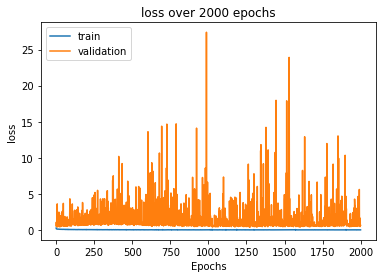

Average Training Score: 0.044447377294081776
Average Validation Score: 1.518897192790873


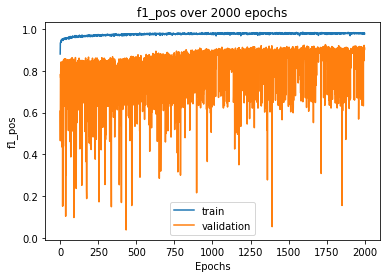

Average Training Score: 0.974474466526619
Average Validation Score: 0.7936693727000755


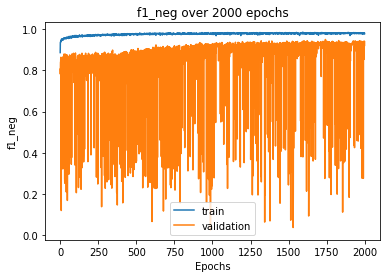

Average Training Score: 0.9755025675705173
Average Validation Score: 0.8109831727081998



In [4]:
from model_utils import create_model_architecture
from train_utils import train

use_gpu = True
device_name = 'cuda' if use_gpu else 'cpu'
print('device_name', device_name)

batch_size = 100

phases = ['train', 'val']
metric_types = ['loss', 'tn', 'fp', 'fn', 'tp', 'f1_pos', 'f1_neg']
metric_types_plot = ['loss', 'f1_pos', 'f1_neg']
metric_names_all = [p+'-'+m for p in phases for m in metric_types]
metric_names_plot = [p+'-'+m for p in phases for m in metric_types_plot]

all_metrics = {metric : [] for metric in metric_names_all}

num_training_epochs = 2000

data_loaders = {t : torch.utils.data.DataLoader(imagefolders[t], batch_size = batch_size, shuffle = True, num_workers = 4)
                for t in phases}

model = create_model_architecture('net1', use_gpu = use_gpu)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trained_model, train_metrics = train(model,
                                     criterion,
                                     optimizer,
                                     data_loaders['train'],
                                     data_loaders['val'],
                                     num_epochs=num_training_epochs,
                                     use_gpu = use_gpu)

all_metrics = train_metrics

for metric in metric_types_plot:
    plot_values(all_metrics['train-' + str(metric)],
               all_metrics['val-' + str(metric)],
               str(metric) + " over " + str(num_training_epochs) + " epochs",
               ylabel = str(metric))

# write metrics to file
# write_metrics_to_csv(all_metrics, metric_names_all, 'net1-IAM-aa_64-raw_logs', 'all_metrics.csv')

print()


In [5]:
# write metrics to file
write_metrics_to_csv(all_metrics, metric_names_all, 'net1-aa_64-2000ep-raw_logs', 'all_metrics.csv')
torch.save(trained_model.state_dict(), 'models/net1-aa_64-2000ep.pt')

Wrote metrics to 'net1-aa_64-2000ep-raw_logs/all_metrics.csv'


In [6]:

# import sys
# import os
# sys.path.append(os.path.abspath('../../../'))
# from detection.lib.model.ImageROI import ImageROI
# from PIL import Image

# # book_data_dir = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images'
# # img_loc = book_data_dir + '/Dryden/positive/307.png'
# # Testing with image of dimensions 1000x1381

# img_loc = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images/Allestree/positive/1307.png'
# pilimg = Image.open(img_loc)
# w, h = pilimg.size
# imgrois = [ImageROI(0, 0, w, h)]
# imgarr = np.asarray(pilimg)

# from bounding_box_classification import get_pos_rois
# # net1 = Net1()

# # Modify this as necessary
# # imgrois = [ImageROI(0, 0, 1000, 700), ImageROI(0, 750, 1000, 500)]
# trained_model.train(False)
# with torch.set_grad_enabled(False):
#     pos_rois = get_pos_rois(trained_model,
#                             (pilimg, imgrois),
#                             model_transform = net1_data_transforms['test'],
#                             model_input_size = (64,64),
#                             stride=(32, 32))

# for rois in pos_rois:
#     for roi in rois:
#         print(roi.toString())
        
# all_rois = [roi for rois in pos_rois for roi in rois]
    
# print('number of pos ROIs found', len(all_rois))

# from detection.lib.ImgProcessor import ImgProcessor
# from detection.lib.utils.Utils import plt_img
# # plot the rois and plot only certain information according to the set
# # imgProcessor = ImgProcessor()
# # img = imgProcessor.loadImage(inFilename=img_loc)
# roi_level_set = set([1])
# plt_img(imgarr, rois=all_rois, roi_level_set=roi_level_set)

In [7]:

# import sys
# import os.path
# sys.path.append(os.path.abspath('../../../'))


# # from detection.lib.ImgProcessor import ImgProcessor
# import matplotlib.pyplot as plt
# import numpy as np
# from detection.lib.utils.Utils import *
# from detection.lib.OCREngine import OCREngine
# import pickle

# from PIL import Image

# # 1. parameters
# # root_dir = './sample'
# # img_id = '639'
# # fname = '%s.png' %img_id
# # ocr_engine = 'cv2'
# # f = '%s/%s' % (root_dir,fname)

# ocr_engine = 'tesseract'
# img_id = '1307'
# fname = '1307.png'
# f = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images/Allestree/positive/1307.png'

# # 2. Load the image
# # imgProcessor = ImgProcessor()
# # img = imgProcessor.loadImage(inFilename=f)
# img = np.asarray(Image.open(f))

# # 3. preprocess the image
# # img = imgProcessor.quickPreprocess(img)

# # 4. load the image ground truth
# # img_roi_ground_truth = all_ground_truth[img_id]

# # 5. define the OCR
# # define engine
# ocr = OCREngine(ocr_engine)
# img_roi_ocr, data_df = ocr.image_to_data(img)

# # plot the rois and plot only certain information according to the set
# # roi_level_set = set([2])
# # rois = [(img_roi_ground_truth,'b'), (img_roi_ocr,'r')]
# rois = [(img_roi_ocr,'r')]
# plt_img(img, rois=rois)#, roi_level_set=roi_level_set)

# # save the plot
# plt.savefig('./result/%s_%s_boxes.png' %(fname,ocr_engine))

# # save the bounding boxes to txt
# # save_rois(img_roi_ground_truth,'./result/%s_imgROIs_ground_truth.txt' %fname)
# save_rois(img_roi_ocr,'./result/%s_imgROIs.txt' %fname)

# # save the bounding boxes to pickle
# # with open('./result/%s_imgROIs.pkl' %fname,'wb') as f:
# #     pickle.dump({'ocr':img_roi_ocr, 'ground_truth':img_roi_ground_truth},f)

